### Tu propia red neuronal con Numpy

En este notebook vamos a construir una red usando solamente numpy y nervios de acero. Será divertido.

<img src="frankenstein.png" style="width:20%">


* ref => https://towardsdatascience.com/building-an-artificial-neural-network-using-pure-numpy-3fe21acc5815

In [1]:
# librerias

import sys
sys.path.append("..")
import tqdm_utils
import download_utils

In [2]:
# usa modelos y datasets precargardos desde keras

download_utils.link_all_keras_resources()

In [3]:
from __future__ import print_function
import numpy as np
np.random.seed(42)

Nuestra clase principal: una capa con metodos .forward() y .backward().

In [4]:
class Capa:
    """
    Un bloque de construccion. Cada capa es capaz de realizar dos cosas:
    
    - Procesar la entrada para dar una salida:               salida = capa.forward(entrada)
    
    - Propagar los gradientes a traves de la propia capa:    grad_in = capa.backward(entrada, grad_out)
    
    Algunas capas tambien tienen parametros de aprendizaje que se actualizan durante el metodo capa.backward.
    """
    def __init__(self):
        """Aqui se pueden inicializar parametros de la capa, si hay alguno, y cosas auxiliares."""
        # Una capa vacia no hace nada
        self.pesos = np.zeros(shape=(input.shape[1], 10))
        sesgos = np.zeros(shape=(10,))
        pass
    
    def forward(self, input):  # propagacion hacia adelante de los datos
        """
        Toma la dimension de los datos de entrada [muestra, unidades_entrada], 
        devuelve datos de salida [muestra, unidades_salida]
        """
        # Una capa vacia solo devuelve la entrada.
        output = np.matmul(input, self.pesos) + sesgos  # multiplicacion matricial
        return output

    def backward(self, input, grad_output):  # propagacion hacia atras del error
        """
        Realiza la propagacion hacia atras a traves de la capa, con respecto a la entrada dada.
        
        Se calculan los gradientes de la perdida de entrada, se necesita aplicar la regla de la cadena:
        
        d perdida / d x  = (d perdida / d capa) * (d capa / d x)
        
        Afortunadamente, se recibe d perdida / d capa como entrada, 
        asi que solo se necesita multiplicar por d capa / d x. (derivadas)
        
        Si na capa tiene parametro,por ejemplo una capa densa (full connected, dense),
        tambien se necesita actualizarla usando d perdida / d capa
        """
        # El gradiente de una capa vacia es precisamente grad_output, pero se escribe explicitamente:
        num_unidades = input.shape[1]
        
        d_capa_d_entrada = np.eye(num_unidades)
        
        return np.dot(grad_output, d_capa_d_entrada) # regla de la cadena, producto escalar

### Camino por delante

Vamos a construir una red neuronal que clasifique números de la base de datos MNIST. Para hacerlo, necesitamos construir algunos bloques:

- Capa densa - capa fully-connected ,  $f(X)=W \cdot X + \vec{b}$
- Capa ReLU (unidad de rectificado lineal o otra capa no lineal que se prefiera)
- Funcion de perdida (entropia cruzada) (loss function - crossentropy)
- Algoritmo de propagacion hacia atras (Backprop algorithm), gradiente descente estocastico

Vamos a verlos uno por uno.


### Capa no lineal

Esta es la capa más simple que se puede tener: simplemente aplica una función no lineal a cada elemento de la red.

In [5]:
class ReLU(Capa):
    def __init__(self):
        """ReLU aplica un rectificado lineal a todas las entradas"""
        pass
    
    def forward(self, input):
        """Aplica ReLU elemento a elemento a la matriz [muestra, unidades_entrada]"""
        return np.maximum(0,input)
    
    def backward(self, input, grad_output):
        """Calcula el gradiente de la perdida para las entradas de ReLU"""
        relu_grad = input > 0
        return grad_output*relu_grad        

In [6]:
# algunas pruebas

from util import eval_numerical_gradient
x = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(x,np.ones([10,32])/(32*10))
num_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, num_grads, rtol=1e-3, atol=0),\
    'el gradiente devuelto por la capa no coincide con el gradiente calculado numericamente' 

#### En primer lugar: funciones lambda 

En python, se pueden definir funciones en una sola linea usando la funcion `lambda`,

que tiene una sintaxis tal que: `lambda param1, param2: expression`


Por ejemplo: `f = lambda x, y: x+y` es equivalente a la funcion:

```
def f(x,y):
    return x+y
```
Para mas informacion,  [aqui](http://www.secnetix.de/olli/Python/lambda_functions.hawk).    

### Capa densa (full connected)

Vamos a construir algo mas complicado. A diferencia de la no linealidad, una capa densa realmente aprende algo.

Una capa densa aplica una transformacion afin. En forma vectorial se puede describir:

$$f(X)= W \cdot X + \vec b $$

Donde 
* X es una matriz de caracteristicas de dimensiones [tamaño_muestra, num_caracteristicas],
* W es una matriz de pesos [num_caracteristicas, num_salidas] 
* b es un vector de sesgos [num_salidas].

Tanto W como b se inicializan durante la creacion de la capa y se actualizan cada vez que se llama al metodo backward().

In [7]:
class Densa(Capa):
    def __init__(self, in_unids, out_unids, tasa=0.1):
        """
        Una capa densa es una capa que realiza una transformacion afin:
        f(x) = <W*x> + b
        tasa es la tasa de aprendizaje de la red (learning rate)
        """
        self.tasa = tasa
        
        # inicializa los pesos con numeros pequeños aleatorios. Se usa un inicio normal, 
        # pero hay mejores maneras de hacerlo. Una vez que te funcione, prueba esto: http://bit.ly/2vTlmaJ
        self.pesos = np.random.randn(in_unids, out_unids)*0.01
        self.sesgos = np.zeros(out_unids)
        
    def forward(self,input):
        """
        Realiza la transformacion afin:
        f(x) = <W*x> + b
        
        dimension de entrada: [muestra, unidades_entrada]
        dimension de salida: [muestra, unidades_salida]
        """
        return np.matmul(input, self.pesos) + self.sesgos
    
    def backward(self,input,grad_output):
        
        # se calcula d f / d x = d f / d densa * d densa / d x
        # donde d densa/ d x = matriz de pesos traspuesta
        grad_input = np.dot(grad_output,np.transpose(self.pesos))
        
        # se calcula el gradiente de los pesos y los sesgos
        grad_pesos = np.transpose(np.dot(np.transpose(grad_output),input))
        grad_sesgos = np.sum(grad_output, axis = 0)
        
        assert grad_pesos.shape == self.pesos.shape and grad_sesgos.shape == self.sesgos.shape
        # Aqui se realiza el paso de gradiente descente estocastico. 
        # Despues, puedes intentar mejorarlo.
        self.pesos = self.pesos - self.tasa * grad_pesos
        self.sesgos = self.sesgos - self.tasa * grad_sesgos
        
        return grad_input

### Testeando la capa densa

Se haran algunos tests para asegurarnos que la capa densa funciona adecuadamente. Si funciona, se printea ¡Bien hecho!

... o no, y tendras que arreglar algo. Para esto alguno consejos:
* Asegurate de calcular los gradientes para pesos y sesgo como __la suma de los gradientes sobre la muestra__. La salida ya está dividida entre el tamaño de la muestra.
* Si estás debbugueando, procura guardar los gradientes en una clase, como "self.grad_w = grad_w" o printea los primeros pesos. Esto ayuda.
* Si nada ayuda, trata de ignorar el test y pasa a la fase de entrenamiento. Si entrena, está pasando algo que no afecta al funcionamiento de la red.

In [8]:
l = Densa(128, 150)

assert -0.05 < l.pesos.mean() < 0.05 and 1e-3 < l.pesos.std() < 1e-1,\
    'Los pesos iniciales deben tener media cero y poca varianza.'\
    'Si sabes lo que haces, borra este assert.'

assert -0.05<l.sesgos.mean()<0.05, 'Los sesgos deben tener media cero. Ignora esto si por alguna razón pones otra cosa'


# Para testear las salidas, explicitamente se ponen valores fijos. ¡NO HACER ESTO CON LA RED REAL!
l = Densa(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.pesos = np.linspace(-1,1,3*4).reshape([3,4])
l.sesgos = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print('¡Bien hecho!')

¡Bien hecho!


In [ ]:
# Para testear los gradientess, usamos los gradientes obtenidos por diferencias finitas

from util import eval_numerical_gradient

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Densa(32, 64, tasa=0)

num_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads, num_grads, rtol=1e-3, atol=0), \
                   'el gradiente de entrada no cuadra con el gradiente numerico'
print('¡Bien hecho!')

¡Bien hecho!


In [ ]:
#testeo de gradientes con parametros

def compute_out_given_wb(p,s):
    l = Densa(32, 64, tasa=1)
    l.pesos = np.array(p)
    l.sesgos = np.array(s)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(p,s):
    l = Densa(32, 64, tasa=1)
    l.pesos = np.array(p)
    l.sesgos = np.array(s)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return  p-l.pesos, s-l.sesgos
    
p,s = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda p: compute_out_given_wb(p,s).mean(0).sum(),p)
numeric_db = eval_numerical_gradient(lambda s: compute_out_given_wb(p,s).mean(0).sum(),s)

grad_w,grad_b = compute_grad_by_params(p,s)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print('¡Bien hecho!')

¡Bien hecho!


### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If you write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If you take a closer look, ya'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

Here you are! We've defined the both loss functions for you so that you could focus on neural network part.

In [ ]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [ ]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

### Full network

Now let's combine what we've just built into a working neural network. As we announced, we're gonna use this monster to classify handwritten digits, so let's get them loaded.

In [ ]:
#import tensorflow as tf                       # quitar texto de tensorflow
#tf.logging.set_verbosity(tf.logging.ERROR)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # quita avisos

Using TensorFlow backend.


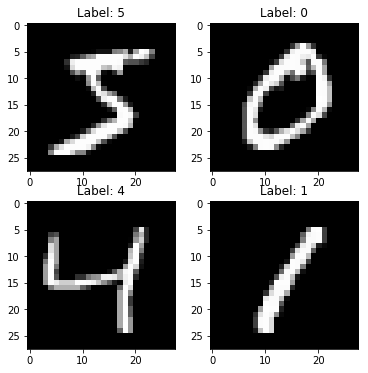

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#import tensorflow as tf                       # quitar texto de tensorflow
#tf.logging.set_verbosity(tf.logging.ERROR)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # quita avisos

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [ ]:
network = []
network.append(Densa(X_train.shape[1],100))
network.append(ReLU())
network.append(Densa(100,200))
network.append(ReLU())
network.append(Densa(200,10))

In [ ]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    for i in range(len(network)):
        activations.append(network[i].forward(X))
        X = network[i].forward(X)
        
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    for i in range(1, len(network)):
        loss_grad = network[len(network) - i].backward(layer_activations[len(network) - i - 1], loss_grad)
        
    return np.mean(loss)

Instead of tests, we provide you with a training loop that prints training and validation accuracies on every epoch.

If your implementation of forward and backward are correct, your accuracy should grow from 90~93% to >97% with the default network.

### Training loop

As usual, we split data into minibatches, feed each such minibatch into the network and update weights.

In [ ]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm_utils.tqdm_notebook_failsafe(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [ ]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 13
Train accuracy: 0.86544
Val accuracy: 0.8757


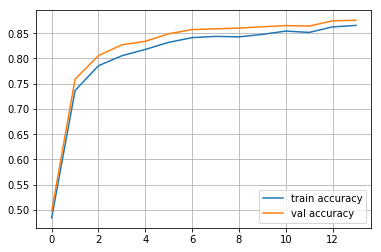

In [ ]:
for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

### Peer-reviewed assignment

Congradulations, you managed to get this far! There is just one quest left undone, and this time you'll get to choose what to do.


#### Option I: initialization
* Implement Dense layer with Xavier initialization as explained [here](http://bit.ly/2vTlmaJ)

To pass this assignment, you must conduct an experiment showing how xavier initialization compares to default initialization on deep networks (5+ layers).


#### Option II: regularization
* Implement a version of Dense layer with L2 regularization penalty: when updating Dense Layer weights, adjust gradients to minimize

$$ Loss = Crossentropy + \alpha \cdot \underset i \sum {w_i}^2 $$

To pass this assignment, you must conduct an experiment showing if regularization mitigates overfitting in case of abundantly large number of neurons. Consider tuning $\alpha$ for better results.

#### Option III: optimization
* Implement a version of Dense layer that uses momentum/rmsprop or whatever method worked best for you last time.

Most of those methods require persistent parameters like momentum direction or moving average grad norm, but you can easily store those params inside your layers.

To pass this assignment, you must conduct an experiment showing how your chosen method performs compared to vanilla SGD.

### General remarks
_Please read the peer-review guidelines before starting this part of the assignment._

In short, a good solution is one that:
* is based on this notebook
* runs in the default course environment with Run All
* its code doesn't cause spontaneous eye bleeding
* its report is easy to read.

_Formally we can't ban you from writing boring reports, but if you bored your reviewer to death, there's noone left alive to give you the grade you want._


### Bonus assignments

As a bonus assignment (no points, just swag), consider implementing Batch Normalization ([guide](https://gab41.lab41.org/batch-normalization-what-the-hey-d480039a9e3b)) or Dropout ([guide](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)). Note, however, that those "layers" behave differently when training and when predicting on test set.

* Dropout:
  * During training: drop units randomly with probability __p__ and multiply everything by __1/(1-p)__
  * During final predicton: do nothing; pretend there's no dropout
  
* Batch normalization
  * During training, it substracts mean-over-batch and divides by std-over-batch and updates mean and variance.
  * During final prediction, it uses accumulated mean and variance.
